## Create Flood Inundation Map based on the HAND Method

**Authors**: Anthony Castronova (acastronova@cuahsi.org), Irene Garousi-Nejad (igarousi@cuahsi.org)  <br>
**Last updated**: Mar 26, 2024

This notebook demonstrates how to generate flood inundation maps using the methodology and datasets defined by https://github.com/noAA-OWP/inundation-mapping. All data used in this notebook are publicly acessible via Amazon AWS. 

This work was funded by:

 <img src="https://www.hydroshare.org/resource/dc269e23ff494a06b7372bc6034a5de2/data/contents/v3-SNOW/logo-img/CUAHSI-4-color-logo_with_URL.png" width="300" height="300" style="padding-right:50px"> <img src="https://www.hydroshare.org/resource/dc269e23ff494a06b7372bc6034a5de2/data/contents/v3-SNOW/logo-img/CIROHLogo_200x200.png" width="100" height="20">    

In [1]:
import numpy
import xarray
import rioxarray
import geopandas
import numpy as np
import pandas as pd
from typing import Dict
from pathlib import Path
from scipy import interpolate
import matplotlib.pyplot as plt
from geocube.api.core import make_geocube

/tmp/ipykernel_13965/1674811969.py:4: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas


Define a feature of interest and a hypothetical streamflow

In [34]:
# Specify the feature of interest
huc_id = "05100101"
nhd_feature_id=2087827

# hypothetical streamflow (cms).
# This can be replaced with a flow value gathered by a source of your choice
cms = 500

## Collect Data

Collect the required input datasets for the FIM computation, we've staged some for public access in the CUAHSI cloud. For access to all available FIM input datasets, please refer to the documentation at https://github.com/noAA-OWP/inundation-mapping. 

In [19]:
# hydroTable_0.csv
!aws --no-sign-request --endpoint-url https://api.minio.cuahsi.io \
 s3 cp s3://scratch/hand_fim/{huc_id}/branches/0/hydroTable_0.csv .

# rem_zeroed_masked_0.tif
!aws --no-sign-request --endpoint-url https://api.minio.cuahsi.io \
 s3 cp s3://scratch/hand_fim/{huc_id}/branches/0/rem_zeroed_masked_0.tif .

# gw_catchments_reaches_filtered_addedAttributes_crosswalked_0.gpkg
!aws --no-sign-request --endpoint-url https://api.minio.cuahsi.io \
s3 cp s3://scratch/hand_fim/{huc_id}/branches/0/gw_catchments_reaches_filtered_addedAttributes_crosswalked_0.gpkg .

# demDerived_reaches for visualization
!aws --no-sign-request --endpoint-url https://api.minio.cuahsi.io \
s3 cp s3://scratch/hand_fim/{huc_id}/branches/0/demDerived_reaches_split_filtered_addedAttributes_crosswalked_0.gpkg .

download: s3://scratch/hand_fim/05100101/branches/0/hydroTable_0.csv to ./hydroTable_0.csv
download: s3://scratch/hand_fim/05100101/branches/0/rem_zeroed_masked_0.tif to ./rem_zeroed_masked_0.tif
download: s3://scratch/hand_fim/05100101/branches/0/gw_catchments_reaches_filtered_addedAttributes_crosswalked_0.gpkg to ./gw_catchments_reaches_filtered_addedAttributes_crosswalked_0.gpkg
download: s3://scratch/hand_fim/05100101/branches/0/demDerived_reaches_split_filtered_addedAttributes_crosswalked_0.gpkg to ./demDerived_reaches_split_filtered_addedAttributes_crosswalked_0.gpkg


Use the streamflow defined above to interpolate river stage from a rating curve for all hydroids that exist within this NHD+ reach. 

In [10]:
def interpolate_y(df: pd.DataFrame,
                  x_column: str,
                  y_column: str,
                  x_value: float) -> float:
    """
    Performs 1D interpolation on two columns of a Dataframe.

    Parameters
    ==========
    df: pandas.DataFrame
        DataFrame containing data that will be used in the interpolation.
    x_column: str
        Name of the column that represents the X-axis data.
    y_column: str
        Name of the column that represents the Y-axis data.
    x_value: float
        Numeric X-axis value for which to interpolate Y-axis data. Returns 
        -9999 if the interpolation fails to resolve.

    Returns
    =======
    y_value: float
        Numeric Y-axis value corresponding to the input X-axis value.

    """
    # Sort the DataFrame by the 'x' column to ensure interpolation works correctly
    df_sorted = df.sort_values(by=x_column)
    
    # Check if the x_value is within the range of the DataFrame
    if x_value < df_sorted[x_column].min() or x_value > df_sorted[x_column].max():
        return -9999  # x_value is out of range, cannot interpolate
    
    # Perform linear interpolation
    f = interpolate.interp1d(df_sorted[x_column], df_sorted[y_column], kind='linear')
    
    # Return the interpolated y value for the given x value
    return f(x_value)

def compute_stage(df: pd.DataFrame,
                  hydro_id: int,
                  flow_cms: float) -> Dict[int, float]:
    """
    Computes river stage from a rating curve given streamflow in cfs.

    Parameters
    ==========
    df: pandas.DataFrame
        DataFrame containing the stage and discharge values of the rating curve.
        This must contain the following columns: HydroID, stage, discharge_cms.
    hydro_id: int
        Identifier for the reach for which to compute stage.
    flow_cms: float
        Streamflow to convert into river stage.

    Returns
    =======
    Dict [int, float]
        A dictionary containing computed stage and its associated hydroid

    """

    
    # look up rating curve for this hydroid
    rating_curve = df.loc[df.HydroID == hydro_id, ['stage', 'discharge_cms']]

    # interpolate using the provided flow rate
    interpolated_stage = interpolate_y(rating_curve, 'discharge_cms', 'stage', flow_cms) 

    return {hydro_id: float(interpolated_stage)}

def get_stage_for_all_hydroids_in_reach(nhd_feature_id: int,
                                        flow_cms: float,
                                        hydrotable: Path = Path('./hydroTable_0.csv')) -> Dict[int, float]:
    """
    Retrieves stage for all NWM HydroIDs given an NHD reach and input streamflow.
    The stage is computed using FIM rating curves.

    Parameters
    ==========
    nhd_feature_id: int
        NHD feature identifier.
    flow_cms: float
        Streamflow for the reach in cubic meters per second
    hydrotable: pathlib.Path
        Path to the FIM hydrotable.csv file containing rating curve data.

    Returns
    =======
    Dict [int, float]
        Dictionary containing one or more NWM hydro identifiers and 
        their corresponding stages.

    """
    
    # load hydrotable_0
    # we don't need all of the columns in this csv
    hydro_df = pd.read_csv(hydrotable,
                           usecols=['HydroID', 'NextDownID', 'feature_id',
                                    'stage', 'discharge_cms'])
    
    # select features that match nhd_feature_id
    d = hydro_df.loc[hydro_df.feature_id==nhd_feature_id]
    
    # get unique combos of HydroID and NextDownID 
    hydro_ids = np.unique(d.HydroID)
    
    interpolated_stages = {}
    for hydro_id in hydro_ids:  
        interpolated_stages.update(compute_stage(d, hydro_id, flow_cms))
        
    # return interpolated stage
    return interpolated_stages


In [39]:
stage_dict = get_stage_for_all_hydroids_in_reach(nhd_feature_id, cms)
stage_dict

{15855736: 4.455933774877808,
 15855737: 4.6663300657201665,
 15855738: 4.196207282291658,
 15855739: 5.513363876148186,
 15855740: 3.369292903053108,
 15855741: 3.690877115580439,
 15855742: 3.87242569665191}

Load the precomputed HAND raster that was obtained from AWS.

In [40]:
xds = rioxarray.open_rasterio(Path('./rem_zeroed_masked_0.tif'),
                              masked=True).squeeze().drop_vars('band').to_dataset(name='hand')
xds

<xarray.Dataset>
Dimensions:      (x: 18146, y: 17087)
Coordinates:
  * x            (x) float64 9.684e+05 9.684e+05 9.684e+05 ... 1.15e+06 1.15e+06
  * y            (y) float64 1.85e+06 1.85e+06 1.85e+06 ... 1.679e+06 1.679e+06
    spatial_ref  int64 0
Data variables:
    hand         (y, x) float32 ...

Make a copy of the 'hand' variable to the 'stage' variable. This will be used to compute the flood inundation map later on. The dataset will now have both `hand` and `stage` variables for all (x,y) locations.

In [41]:
xds['stage'] = xds.hand.copy(deep=True)
xds

<xarray.Dataset>
Dimensions:      (x: 18146, y: 17087)
Coordinates:
  * x            (x) float64 9.684e+05 9.684e+05 9.684e+05 ... 1.15e+06 1.15e+06
  * y            (y) float64 1.85e+06 1.85e+06 1.85e+06 ... 1.679e+06 1.679e+06
    spatial_ref  int64 0
Data variables:
    hand         (y, x) float32 ...
    stage        (y, x) float32 ...

Read watershed geometries and set stage values from the `stage_dict` defined above, and remove all other geometries. The end product will be a geodataframe containing the geometries for each `hydroid` in our area of interest and their stage values.

In [42]:
geodf = geopandas.read_file(Path('./gw_catchments_reaches_filtered_addedAttributes_crosswalked_0.gpkg'))
geodf_reaches = geopandas.read_file(Path('./demDerived_reaches_split_filtered_addedAttributes_crosswalked_0.gpkg'))

# loop over each reach and set the corresponding stage
# in the geopandas object
for hydroid, stage in stage_dict.items():
    geodf.loc[geodf.HydroID==hydroid, 'stage'] = stage

# remove all nan values to make our dataset smaller
geodf_filtered = geodf[geodf.stage.notnull()]

# isolate only reaches we're interested in to make our dataset smaller
geodf_reaches_filtered = geodf_reaches[geodf_reaches.feature_id == nhd_feature_id]

geodf_filtered

,HydroID,S0,LengthKm,LakeID,From_Node,To_Node,NextDownID,areasqkm,feature_id,order_,src_calibrated,geometry,stage
102,15855742,0.013905,1.328823,-999.0,7028,2416,15851118,0.9663,2087827,1,False,"POLYGON ((981299.409 1831984.282, 981379.409 1...",3.872426
112,15855741,0.016090,1.379533,-999.0,7027,7028,15855742,1.6989,2087827,1,False,"POLYGON ((981919.409 1831464.282, 981959.409 1...",3.690877
119,15855739,0.004631,1.387817,-999.0,7025,7026,15855740,1.5420,2087827,1,False,"POLYGON ((982469.409 1829784.282, 982539.409 1...",5.513364
135,15855738,0.004556,1.383970,-999.0,7024,7025,15855739,2.2252,2087827,1,False,"POLYGON ((982279.409 1828684.282, 982299.409 1...",4.196207
139,15855740,0.012948,1.383675,-999.0,7026,7027,15855741,6.3783,2087827,1,False,"POLYGON ((983179.409 1831234.282, 983249.409 1...",3.369293
148,15855737,0.004348,1.385980,-999.0,7023,7024,15855738,3.1784,2087827,1,False,"POLYGON ((982649.409 1827494.282, 982769.409 1...",4.666330
161,15855736,0.005964,1.379828,-999.0,7022,7023,15855737,2.8203,2087827,1,False,"POLYGON ((982149.409 1826384.282, 982179.409 1...",4.455934


Visualize the area that we're working with.

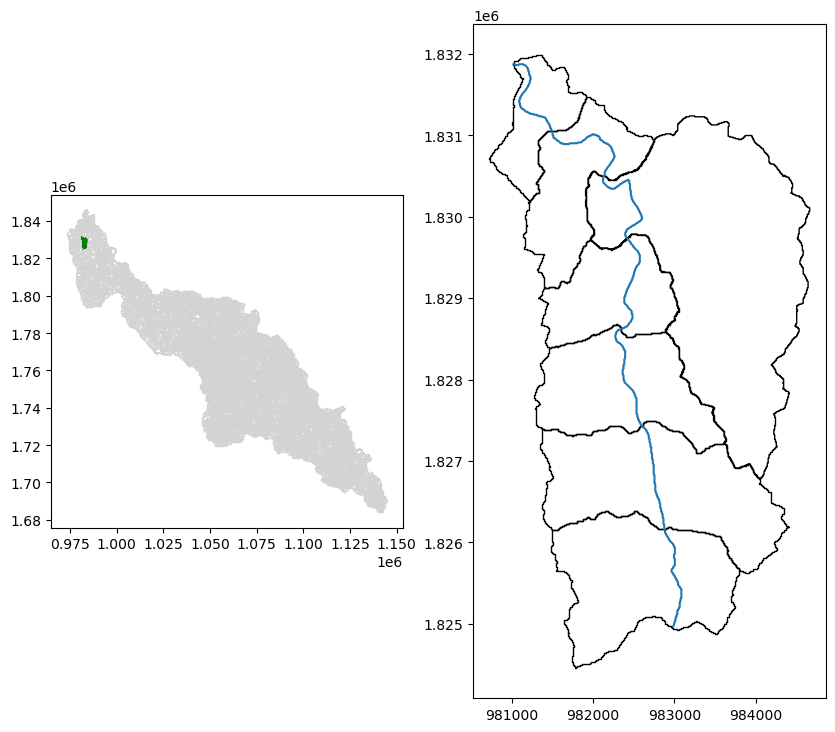

In [43]:
figure, axes = plt.subplots(1, 2, figsize=(10, 10))

geodf.plot(facecolor='None', edgecolor='lightgrey', ax=axes[0]);
geodf_filtered.plot(facecolor='green', ax=axes[0]);

geodf_filtered.plot(facecolor='None', ax=axes[1]);
geodf_reaches_filtered.plot(ax=axes[1]);

Add all geometries to the Dataset containing `hand` and `stage` variables using a GeoCube.

In [44]:
# create a grid for the geocube
out_grid = make_geocube(
    vector_data=geodf,
    measurements=['HydroID'],
    like=xds # ensure the data are on the same grid
)

# add stage and hydroID to the HAND raster
ds = xds.assign_coords( hydroid = (['y', 'x'], out_grid.HydroID.data) )

# drop everything except the HydroIDs that we're interested in
ds = ds.where(ds.hydroid.isin(geodf_filtered.HydroID), drop=True)
ds

<xarray.Dataset>
Dimensions:      (y: 752, x: 393)
Coordinates:
  * x            (x) float64 9.807e+05 9.807e+05 ... 9.846e+05 9.847e+05
  * y            (y) float64 1.832e+06 1.832e+06 ... 1.824e+06 1.824e+06
    spatial_ref  int64 0
    hydroid      (y, x) float64 1.585e+07 1.585e+07 ... 1.586e+07 1.586e+07
Data variables:
    hand         (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    stage        (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan

Update the stage values in the DataSet where specific hydroid's exist.

In [45]:
for idx, row in geodf_filtered.iterrows():
    print(f'{row.HydroID} -> {row.stage}' )
    ds['stage'] = xarray.where(ds.hydroid == row.HydroID, row.stage, ds.stage)

15855742 -> 3.87242569665191
15855741 -> 3.690877115580439
15855739 -> 5.513363876148186
15855738 -> 4.196207282291658
15855740 -> 3.369292903053108
15855737 -> 4.6663300657201665
15855736 -> 4.455933774877808


Preview the `stage` data we set as well as the original `hand` data. 

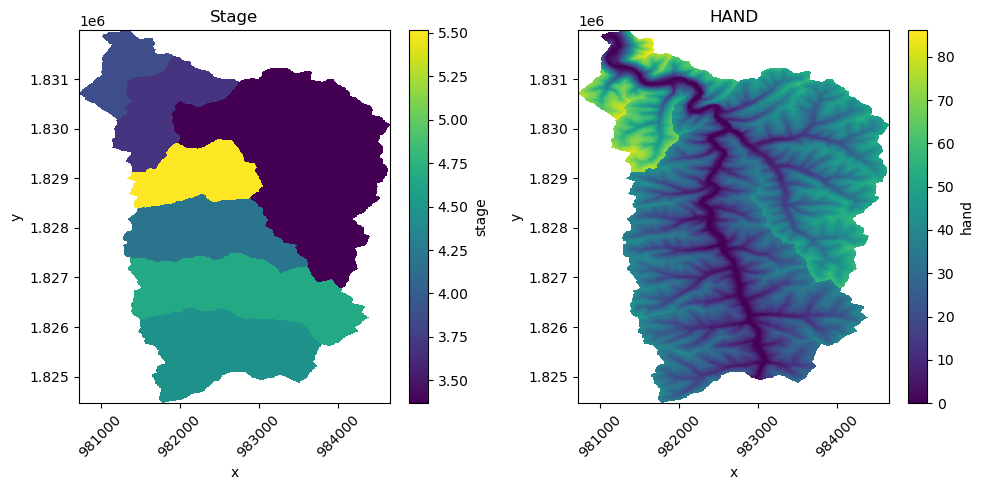

In [46]:
figure, axes = plt.subplots(1, 2, figsize=(10,5))

# plot stage
ds.stage.plot(ax=axes[0])
axes[0].set_title('Stage');
axes[0].tick_params(axis='x', labelrotation=45)

# plot hand
ds.hand.plot(ax=axes[1])
axes[1].set_title('HAND');
axes[1].tick_params(axis='x', labelrotation=45)

figure.tight_layout()


Compute FIM by subtracting `hand` from `stage`. Everything that is negative should be set to zero. Cells that have a value greater than zero indicate areas in which flooding occurs. Create a new variable in our dataset (called `fim`) to store this result.

In [47]:
ds['fim'] = ds.stage - ds.hand
ds['fim'] = xarray.where(ds.fim >= 0.00001, ds.fim, numpy.nan)

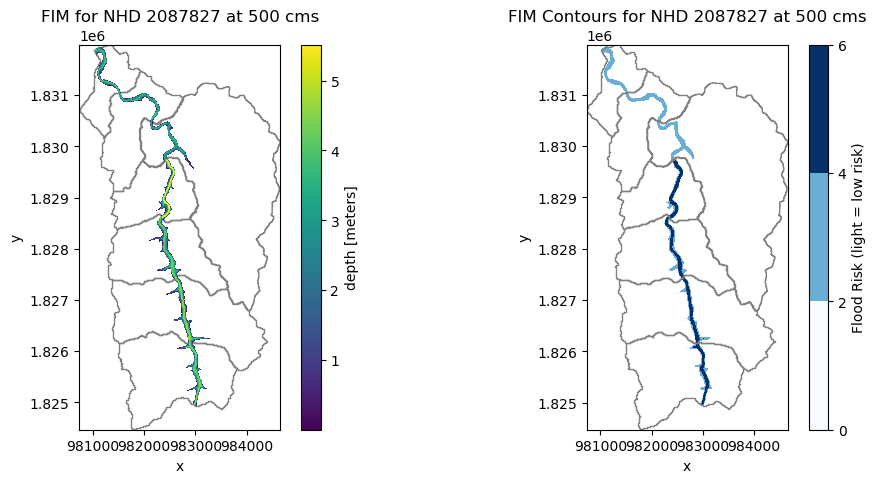

In [48]:
figure, axes = plt.subplots(1, 2, figsize=(12,5))

geodf.loc[geodf.feature_id==nhd_feature_id].plot(ax=axes[0], edgecolor='grey', facecolor='None');
ds.fim.plot(cbar_kwargs={'label':'depth [meters]'}, ax=axes[0]);
axes[0].set_title(f'FIM for NHD {nhd_feature_id} at {cms} cms');


xarray.plot.contourf(ds.fim, levels=4, cmap='Blues', cbar_kwargs={'label':'Flood Risk (light = low risk)'}, ax=axes[1]);
geodf.loc[geodf.feature_id==nhd_feature_id].plot(ax=axes[1], edgecolor='grey', facecolor='None');
axes[1].set_title(f'FIM Contours for NHD {nhd_feature_id} at {cms} cms');


Plot interactively

In [57]:
import hvplot.xarray
ds.fim.hvplot(invert=True, aspect='equal', frame_width=400)

:Image   [y,x]   (fim)